In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
from pandas.tseries.offsets import BDay
seaborn.set()

# Simulace pro už známou dobu

V tomto případě používám opět data pro červencový futures kontrakt na ropu 2020, opci tady ale oceňuji k 31/12, ke kterému už mám známou cenu.Výchozí bod od kterého se budou simulovat průběhy je 31/10/2019.

Výpočet je pouze teoretický, protože pro asijskou opci začíná její průměrovací období až v květnu 2020.

Opce bude asijská typu CALL

Výpočty:
simulační model
výpočet ceny opce z opravdových hodnot
výpočet přes vzorec

In [2]:
raw_data = pd.read_csv("datasets/CLN20.NYM.csv")
data1 = raw_data.set_index(raw_data.columns[0])

contract_raw = data1.iloc[:,3]
contract_raw = contract_raw["2019-05-06":"2019-12-31"]
contract_raw.index = pd.to_datetime(contract_raw.index)
contract_raw = contract_raw.asfreq(BDay())
contract_raw = contract_raw.fillna(method='ffill').dropna()
contract_raw.tail()

pct_ch = contract_raw.pct_change()
contract = pd.DataFrame({"contract":contract_raw,"%change":pct_ch}, index=contract_raw.index).dropna()
contract["logreturn"] = np.log(contract_raw/contract_raw.shift(1))
contract["delta"] = contract_raw - contract_raw.shift(1)
contract["shifted_contract"] = contract_raw.shift()

contract.tail()

,contract,%change,logreturn,delta,shifted_contract
Date,,,,,
2019-12-25,58.669998,0.000000,0.000000,0.000000,58.669998
2019-12-26,59.590000,0.015681,0.015559,0.920002,58.669998
2019-12-27,59.590000,0.000000,0.000000,0.000000,59.590000
2019-12-30,59.459999,-0.002182,-0.002184,-0.130001,59.590000
2019-12-31,59.040001,-0.007064,-0.007089,-0.419998,59.459999


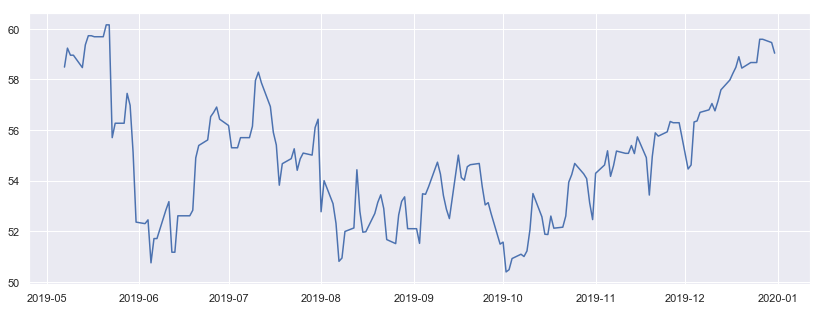

In [3]:
plt.figure(figsize=(14,5))
plt.plot(contract.iloc[:,0])
#plt.plot(contract.iloc[:,4], "--")

In [4]:
contract_known = contract["2019-05-06":"2019-10-31"]

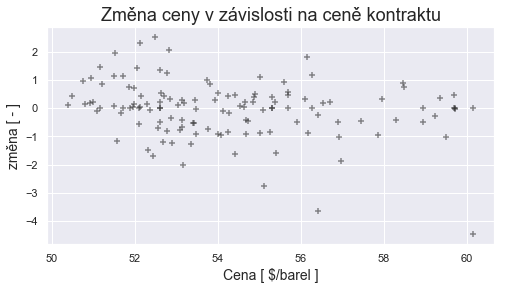

In [5]:

fig, ax = plt.subplots(figsize=(8,4))
ax.set_title("Změna ceny v závislosti na ceně kontraktu", fontsize=18)
ax.scatter(contract_known["shifted_contract"], contract_known["delta"], c="k", marker="+", alpha=0.5)
ax.set_ylabel("změna [ - ]",fontsize=14)
ax.set_xlabel("Cena [ $/barel ]",fontsize=14)
fig.savefig('CLN20.NYM_scatter.pdf', format='pdf', bbox_inches='tight')

In [6]:
import statsmodels.api as sm


Regrese s %change [ - ] jako závislou proměnnou a výchozí hodnotou jako nezávislou proměnnou

In [7]:
y4 = contract_known["%change"]
X4 = sm.add_constant(contract_known["shifted_contract"])

res4 = sm.OLS(y4,X4).fit()
res4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                %change   R-squared:                       0.057
Model:                            OLS   Adj. R-squared:                  0.049
Method:                 Least Squares   F-statistic:                     7.579
Date:                Sat, 02 May 2020   Prob (F-statistic):            0.00678
Time:                        22:43:22   Log-Likelihood:                 335.11
No. Observations:                 128   AIC:                            -666.2
Df Residuals:                     126   BIC:                            -660.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.0944      0.035      2.727      0.007       0.026       0.163
shifted_contract    -0.0018      0.001     -2.753      0.007      -0.003      -0.000
==============================================================================
Omnibus:                       15.279   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               23.293
Skew:                          -0.595   Prob(JB):                     8.75e-06
Kurtosis:                       4.718   Cond. No.                     1.20e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
print(res4.params)
print("a = ", res4.params[0])
print("b = ", res4.params[1])
print(f"kappa = {-res4.params[1]}")
print(f"mean = {-res4.params[0]/res4.params[1]}")
print(f"volatility = {res4.resid.std()}")

const               0.094359
shifted_contract   -0.001754
dtype: float64
a =  0.094359278282684
b =  -0.0017537290270949531
kappa = 0.0017537290270949531
mean = 53.80493612459039
volatility = 0.01771974398082624


Regrese s rozdílem mezi 2 cenami = delta [ $ ] jako závislou proměnnou a výchozí hodnotou jako nezávislou proměnnou

In [9]:
y1 = contract_known["delta"]
X1 = sm.add_constant(contract_known["shifted_contract"])

res1 = sm.OLS(y1,X1).fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  delta   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     7.738
Date:                Sat, 02 May 2020   Prob (F-statistic):            0.00624
Time:                        22:43:22   Log-Likelihood:                -177.24
No. Observations:                 128   AIC:                             358.5
Df Residuals:                     126   BIC:                             364.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.2105      1.895      2.750      0.007       1.461       8.960
shifted_contract    -0.0970      0.035     -2.782      0.006      -0.166      -0.028
==============================================================================
Omnibus:                       22.236   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.137
Skew:                          -0.764   Prob(JB):                     1.17e-09
Kurtosis:                       5.320   Cond. No.                     1.20e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [10]:
print(res1.params)
print("a = ", res1.params[0])
print("b = ", res1.params[1])
print(f"kappa = {-res1.params[1]}")
print(f"mean = {-res1.params[0]/res1.params[1]}")
print(f"volatility = {res1.resid.std()}")

const               5.210481
shifted_contract   -0.097023
dtype: float64
a =  5.21048066551088
b =  -0.09702280494912091
kappa = 0.09702280494912091
mean = 53.70366965007117
volatility = 0.9701629383905664


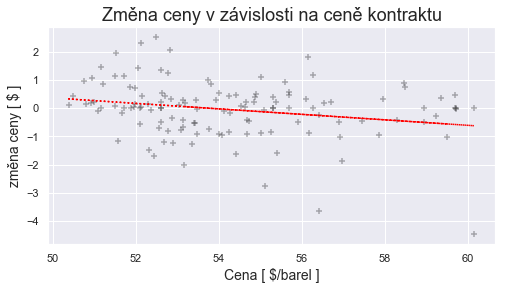

In [11]:
yhat1 = res1.params[0] + res1.params[1] * contract_known["shifted_contract"]

fig, ax = plt.subplots(figsize=(8,4))
ax.set_title("Změna ceny v závislosti na ceně kontraktu", fontsize=18)
ax.scatter(contract_known["shifted_contract"], contract_known["delta"], c="black", marker="+", alpha=0.3 )
ax.plot(contract_known["shifted_contract"], yhat1, linestyle=":", color="red")
ax.set_ylabel("změna ceny [ $ ]",fontsize=14)
ax.set_xlabel("Cena [ $/barel ]",fontsize=14)
fig.savefig('lin_reg_normal.pdf', format='pdf', bbox_inches='tight')

In [12]:
reshc3 = res1.get_robustcov_results(cov_type="HC3")
reshc3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  delta   R-squared:                       0.058
Model:                            OLS   Adj. R-squared:                  0.050
Method:                 Least Squares   F-statistic:                     5.267
Date:                Sat, 02 May 2020   Prob (F-statistic):             0.0234
Time:                        22:43:23   Log-Likelihood:                -177.24
No. Observations:                 128   AIC:                             358.5
Df Residuals:                     126   BIC:                             364.2
Df Model:                           1                                         
Covariance Type:                  HC3                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const                5.2105      2.272      2.294      0.023       0.715       9.706
shifted_contract    -0.0970      0.042     -2.295      0.023      -0.181      -0.013
==============================================================================
Omnibus:                       22.236   Durbin-Watson:                   1.942
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               41.137
Skew:                          -0.764   Prob(JB):                     1.17e-09
Kurtosis:                       5.320   Cond. No.                     1.20e+03
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC3)
[2] The condition number is large, 1.2e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
print("a = ", reshc3.params[0])
print("b = ", reshc3.params[1])
print(f"kappa = {-reshc3.params[1]}")
print(f"mean = {-reshc3.params[0]/reshc3.params[1]}")
print(f"volatility = {reshc3.resid.std()}")

a =  5.21048066551088
b =  -0.09702280494912091
kappa = 0.09702280494912091
mean = 53.70366965007117
volatility = 0.9663658086015992


In [14]:
from statsmodels.stats.diagnostic import het_white
white1 = het_white(res1.resid,X1)
white1

(3.4091361899347135,
 0.18185091154028174,
 1.7101656201351898,
 0.18503939590959673)

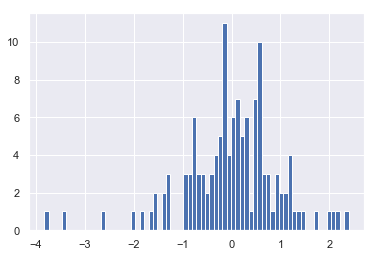

In [15]:
plt.hist(reshc3.resid,bins=70)
plt.show()

In [16]:
from auxiliary.distribution_fit import distribution_fit
par_res = distribution_fit(reshc3.resid)
par_res

Parameters are in this format: (location, scale)
(-6.661338147750939e-16, 0.9663658086015992)
(4.036211752262796, 0.05851052288545079, 0.7090580123034256)
(0.08150975842878358, 0.48143142106302916)
(-6.561157867013277e-16, 0.7038769155332361)

The larger the p-value, the better
Normal:  0.20974621747316766
Student t KstestResult(statistic=0.0419460756173376, pvalue=0.977932388021189)
Cauchy:  KstestResult(statistic=0.07016462931104228, pvalue=0.541640409841921)
Laplace:  KstestResult(statistic=0.07178008390982493, pvalue=0.5101932350298714)
TE  [-6.661338147750939e-16, 0.9663658086015992, 0.20974621747316766]


,Normal,T,Cauchy,Laplace
Loc,-6.661338e-16,0.058511,0.081510,-6.561158e-16
Scale,9.663658e-01,0.709058,0.481431,7.038769e-01
p (KSTest),2.097462e-01,0.977932,0.541640,5.101932e-01


In [17]:
from statsmodels.stats.stattools import jarque_bera
j1 = jarque_bera(reshc3.resid)
j1

(41.137117198594524,
 1.1673161648504201e-09,
 -0.7636600413195631,
 5.319591093254086)

Výpočet dnů do expirace

In [18]:
contract_raw_all = data1.iloc[:,3]
contract_raw_all = contract_raw_all["2019-05-06":]
contract_raw_all.index = pd.to_datetime(contract_raw_all.index)
contract_raw_all = contract_raw_all.asfreq(BDay())
contract_raw_all = contract_raw_all.fillna(method='ffill').dropna()
contract_raw_all.tail()

Date
2020-04-03    33.000000
2020-04-06    32.799999
2020-04-07    32.040001
2020-04-08    33.470001
2020-04-09    32.029999
Freq: B, Name: Close, dtype: float64

In [19]:
from auxiliary.ContractCalendar import ContractCalendar


asian_december_19_settle = contract.index[-1]
print(asian_december_19_settle)
averaging_days = ContractCalendar.get_business_days_in_month(end_of_month=asian_december_19_settle)
print(averaging_days)
print(len(averaging_days))
all_days = ContractCalendar.get_business_days(start=contract_known.index[-1],end=asian_december_19_settle)
print(all_days)
print(len(all_days))


2019-12-31 00:00:00
DatetimeIndex(['2019-12-02', '2019-12-03', '2019-12-04', '2019-12-05',
               '2019-12-06', '2019-12-09', '2019-12-10', '2019-12-11',
               '2019-12-12', '2019-12-13', '2019-12-16', '2019-12-17',
               '2019-12-18', '2019-12-19', '2019-12-20', '2019-12-23',
               '2019-12-24', '2019-12-25', '2019-12-26', '2019-12-27',
               '2019-12-30', '2019-12-31'],
              dtype='datetime64[ns]', freq='B')
22
DatetimeIndex(['2019-10-31', '2019-11-01', '2019-11-04', '2019-11-05',
               '2019-11-06', '2019-11-07', '2019-11-08', '2019-11-11',
               '2019-11-12', '2019-11-13', '2019-11-14', '2019-11-15',
               '2019-11-18', '2019-11-19', '2019-11-20', '2019-11-21',
               '2019-11-22', '2019-11-25', '2019-11-26', '2019-11-27',
               '2019-11-28', '2019-11-29', '2019-12-02', '2019-12-03',
               '2019-12-04', '2019-12-05', '2019-12-06', '2019-12-09',
               '2019-12-10', '201

In [20]:
contract_known.iloc[-1,3]

-0.6700020000000038

Simulace

In [21]:
from simulations.simulations import asian_simulation_mean_reverting_final

In [22]:
pos = "c"
init_price = contract_known.iloc[-1,0]
strike = 50
sim = 10000
steps = len(all_days)-1 # jedna se musi odecist protoze prvni den je ten vychozi, uz pro nej hodnotu zname
avg_steps=len(averaging_days)
avg_values=[]
group = (0.058511,0.709058,4.0362,"t")
# using the values from delta regression with HC3
mean_value = 53.70
reversion_speed = 0.097

np.random.seed(19121995)

total,paths, payoffs = asian_simulation_mean_reverting_final(position_flag=pos,initial_price=init_price, strike=strike, simulations=sim, steps=steps,
                                avg_steps=avg_steps , avg_values=avg_values, group=group,
                                 mean_value=mean_value, reversion_speed=reversion_speed ,strike_type="fixed")
    
print(total)

42343.72682774955


Výsledek

In [23]:
maturity = (len(all_days)-1)/252
discount_rate = 0.0214 #2.14 % (yearly value) pribor rate for 2 months n 31/10/2019
import numpy as np
(np.exp(-discount_rate*maturity)/sim)*total

4.218938697678183

In [24]:
(len(all_days)-1)

43

Parametry pro vzorec

In [25]:
sigma = contract_known.iloc[:,1].std()

time_to_avg = (steps-1 - avg_steps)/252

params = pd.DataFrame(
                        {"Params":[init_price,0, strike,time_to_avg, maturity, avg_steps, 0, discount_rate * 100, (sigma * np.sqrt(252) * 100)]},
                        index=["S","SA","X","t","Maturity","n","m","r","sigma"]
                        )
params

,Params
S,52.459999
SA,0.000000
X,50.000000
t,0.079365
Maturity,0.170635
n,22.000000
m,0.000000
r,2.140000
sigma,28.962851


In [26]:
# result using Curran's approximation is $3.41
# discrete asian approximation is $3.41 as well

Výpočet průměrné hodnoty z opravdových hodnot

In [27]:
contract_real=contract["2019-12-01":"2019-12-31"]
real_avg = contract_real["contract"].mean()
real_avg

57.70636336363635

Graf s vygenerovanými cenami a s opravdovým průběhem

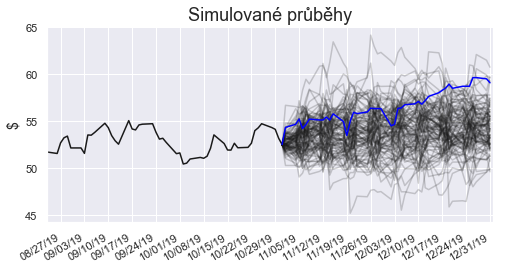

In [28]:
import matplotlib.dates as mdates

week = mdates.WeekdayLocator()
fmt = mdates.DateFormatter('%D')

fig, ax = plt.subplots(1, 1, figsize=(8,4))
ax.set_title("Simulované průběhy", fontsize=18)
ax.plot(contract_known.iloc[-50:,0],color="k")
for path in paths[:100]:
    ax.plot(all_days, path, color="k", alpha=0.2)
ax.plot(contract["2019-10-31":]["contract"],color="blue")
ax.set_ylabel("$",fontsize=14)
ax.xaxis.set_major_locator(week)
ax.xaxis.set_major_formatter(fmt)
ax.set_xlim(contract_known.index[-50], all_days[-1]+BDay())
fig.autofmt_xdate()
plt.show()
fig.savefig('sim_asian_mean_reverting_2.pdf', format='pdf', bbox_inches='tight')

In [29]:
#paths[78]

In [30]:
s = pd.Series(payoffs)
s.std()

1.7139319903072388

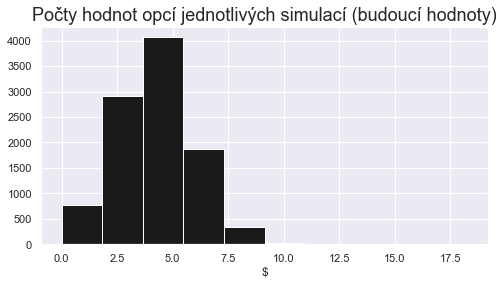

In [31]:
plt.figure(figsize=(8, 4))
plt.title("Počty hodnot opcí jednotlivých simulací (budoucí hodnoty)", fontsize=18)
plt.xlabel("$")
plt.hist(s, bins=10, color="k")
plt.plot()
plt.savefig('sim_asian_payoffs_mean_reverting.pdf', format='pdf', bbox_inches='tight')

In [32]:
se = s.std()/np.sqrt(sim)
se

0.017139319903072388

Opravdová cena

In [33]:
if pos == "c":
    real_payoff = real_avg - strike
elif pos == "p":
    real_payoff = strike - real_avg
    
print(max(real_payoff,0))

7.706363363636349


In [34]:
(np.exp(-discount_rate*maturity))*max(real_payoff,0)

7.678274221226068